# Predicting Disease and Explaining Predictions

## Using XGBoost and SHAP on GSE93272 dataset

This notebook was created using Anaconda Navigator v2.3.2, with Jupyter Notebook v6.4.12, running Python v3.9.13.  If necessary use pip to install sklearn, xgboost and shap.

The data was downloaded from SYNAPSE
https://www.synapse.org/#!Synapse:syn8483403/files/

Using R, added a column to the clinical file, DiseaseControl, assigning value 0 for HC and 1 to patients with RA.  With the gene expression matrix, created a new column SYMBOL with only the gene symbol information from the ProbeID column.  Used Limma avereps function to ensure the matrix is summarised at the gene symbol.  Finally, ensured the order of the samples match the order in the clinical file

In [1]:
# Load libraries
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read data 
# The order of the samples must in the same in both files
clin = pd.read_csv('output/clin_drugnaive.csv', header = 0, index_col=0) # clinical data
data = pd.read_csv('output/edata_drugnaive_norm.csv', header = 0, index_col = 0) # gene expression
data = data.T

clin.head()

,INDIVIDUAL.ID,AGE,GENDER,DISEASE,CDAI,HAQ,D.VAS,PAIN.VAS,SYMPTOM.VAS,TJC66.68,...,SDAI,TJC28,SJC28,TJC38,SJS38,RF,CCP,ANA,MORNING.STIFFNESS,DiseaseControl
SAMPLE.ID,,,,,,,,,,,,,,,,,,,,,
HC004_1,HC004,40,F,HC,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
HC006_1,HC006,50,F,HC,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
HC007_1,HC007,31,F,HC,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
HC009_1,HC009,43,F,HC,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
HC010_1,HC010,25,F,HC,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [3]:
print("clin shape", clin.shape)

clin shape (80, 27)


In [4]:
data.head()

,NAT1,ABAT,ABCA1,ABCA2,ABCB7,ABCF1,AOC1,ABL2,ABR,ACACA,...,LOC100996724,LOC102724701,LOC105376287,LOC101929894,KCNA3,MFSD7,MFSD12,LOC100289097,LOC105372024,LOC440600
HC004_1,5.409561,9.352302,7.565980,6.476872,6.162995,9.225497,5.320169,7.563100,9.156290,7.161593,...,3.481095,3.462564,6.044023,3.797007,6.734590,5.780893,7.649459,6.170714,4.081296,5.355008
HC006_1,5.106272,9.387455,7.973657,6.084679,6.406906,9.282639,5.774804,7.663200,9.373226,7.317526,...,3.428061,3.380469,5.859383,3.399540,6.684602,5.736570,7.409795,6.084645,4.216102,5.724386
HC007_1,5.822885,8.955626,9.215607,5.833432,6.885749,9.357411,5.325130,7.990493,9.054638,7.110230,...,3.469623,2.819714,5.846271,3.255484,6.146701,5.571114,7.903099,6.288444,4.219147,5.300392
HC009_1,5.649460,9.100042,8.816762,4.662936,6.333630,9.151837,5.248819,7.762733,9.020740,6.941921,...,3.966031,3.220701,5.672453,3.617234,5.785951,5.743284,7.533657,6.009769,4.090486,5.780367
HC010_1,5.448661,9.122066,7.820356,6.062214,6.731669,9.461747,5.494267,7.881655,9.170100,7.413654,...,3.758257,3.375354,5.634437,3.956780,6.668385,5.987787,8.044114,6.423362,4.186203,5.557759


In [5]:
print("data shape", data.shape)

data shape (80, 10527)


In [6]:
# Scale the data for PCA and t-SNE
data_scaled = StandardScaler().fit_transform(data)

In [7]:
# Prepare the first 2 PCA components and plot
pca_2c = PCA(n_components = 2)
pca_2c_features = pca_2c.fit_transform(data_scaled)

pca_2c_df = pd.DataFrame(
    data = pca_2c_features, 
    columns = ['PC1', 'PC2'])

target = list(clin['DISEASE'])

pca_2c_df['target'] = target

expl_var = round(sum(pca_2c.explained_variance_ratio_) * 100, 2)

pca1_expl_var = round(pca_2c.explained_variance_ratio_[0] * 100, 2)
pca2_expl_var = round(pca_2c.explained_variance_ratio_[1] * 100, 2)

x_title = "PC1 (" + str(pca1_expl_var) + "%)"
y_title = "PC2 (" + str(pca2_expl_var) + "%)"

sub_title = "(Explained variance for PC1 and PC2 : " + str(expl_var) + "%)"
title = "PCA Plot \n" + sub_title

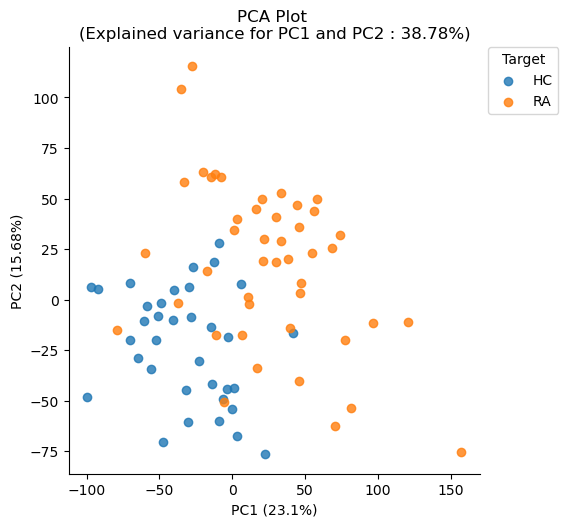

In [8]:
# Plot the first 2 PCA components

sns.lmplot(
    x = 'PC1', 
    y = 'PC2',
    data = pca_2c_df,
    hue = 'target',
    fit_reg = False,
    legend = False
)
plt.title(title)
plt.legend(bbox_to_anchor=(1.02, 1), loc = 'upper left', borderaxespad = 0, title = 'Target')
plt.xlabel(x_title)
plt.ylabel(y_title)
plt.show()

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


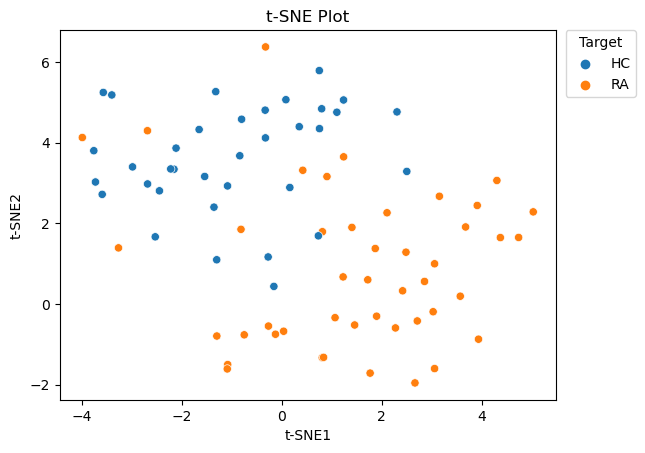

In [9]:
# t-SNE plot
tsne = TSNE(random_state=0)
tsne_results = tsne.fit_transform(data_scaled)
tsne_results = pd.DataFrame(tsne_results, columns = ['t-SNE1', 't-SNE2'])
tsne_results['target'] = target

sns.scatterplot(data = tsne_results, 
                x = "t-SNE1", 
                y = "t-SNE2",
                hue = 'target',
                legend = True
               )
plt.title('t-SNE Plot')
plt.legend(bbox_to_anchor=(1.02, 1), loc = 'upper left', borderaxespad = 0, title = 'Target')
plt.show()

In [10]:
# Assign response, and split data for train and test
y =  clin["DiseaseControl"]
X_train, X_test, y_train, y_test = train_test_split(data,
                                                    y,
                                                    test_size = 0.3, 
                                                    random_state = 132)   
print("X_train shape", X_train.shape)
print("X_test shape", X_test.shape)

X_train shape (56, 10527)
X_test shape (24, 10527)


In [11]:
# Initiate and train the model
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
param = {'max_depth': 4,                       #  this has to be optimised for your model, range between 0->
         'eta': 0.5,                           #  this has to be optimised for your model, range between 0-1
         'objective': 'binary:logistic',       #  this depends on the nature of your model
        }

param['eval_metric'] = 'auc'                   #  this depends on the objective 
num_round = 100                                # number of rounds for boosting
evallist = [(dtest, 'eval'),(dtrain, 'train')] # eval test
progress = {}
model = xgb.train(param, dtrain, num_round, 
                     evals=evallist, evals_result = progress, 
                     verbose_eval=10, 
                     early_stopping_rounds=25) 

# classes in y_test
print(" ")
print("bincount y_test:", np.bincount(y_test))

[0]	eval-auc:0.71429	train-auc:0.97613
[10]	eval-auc:0.95714	train-auc:1.00000
[20]	eval-auc:0.95714	train-auc:1.00000
[25]	eval-auc:0.95714	train-auc:1.00000
 
bincount y_test: [10 14]


In [12]:
# Generate test predictions and assign to the nearest classification
preds = model.predict(dtest)
prediction =[]
for i in preds:
    if i >=0.5:
        prediction.append(1)
    else:
        prediction.append(0)
print("bincount prediction:", np.bincount(prediction))

bincount prediction: [ 9 15]


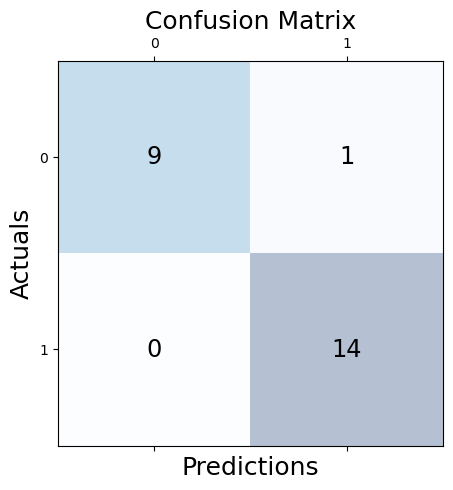

In [13]:
conf_matrix = confusion_matrix(y_true = y_test, y_pred = prediction)

# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [14]:
# Scores
print('Accuracy: %.3f' % accuracy_score(y_test, prediction))
print('F1 Score: %.3f' % f1_score(y_test, prediction))
print('Precision: %.3f' % precision_score(y_test, prediction))
print('Recall: %.3f' % recall_score(y_test, prediction))

Accuracy: 0.958
F1 Score: 0.966
Precision: 0.933
Recall: 1.000


### ROC curve

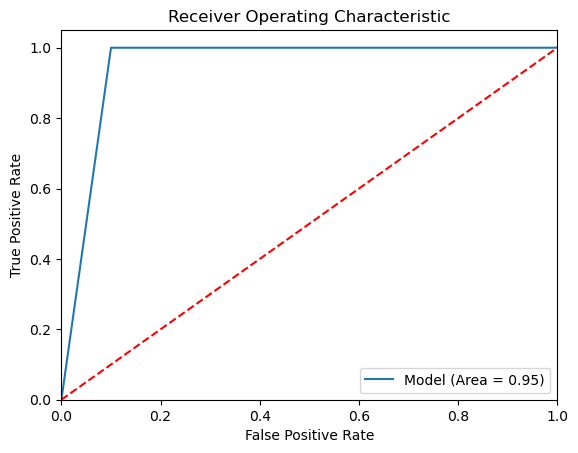

In [15]:
y_true = np.array(y_test.values)
pred_array = np.array(prediction)
roc = roc_auc_score(y_true, pred_array)

fpr, tpr, thresholds = roc_curve(y_true, pred_array) 
plt.figure()
plt.plot(fpr, tpr, label='Model (Area = %0.2f)' % roc) 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('XGBoost_ROC')
plt.show()

## Explaining the predictions using SHAP

https://medium.com/dataman-in-ai/explain-your-model-with-the-shap-values-bc36aac4de3d

A Shapley value is the average of the marginal contributions across all permuations.

The SHAP (SHapley Additive exPlanation) value plot can show the positive and negative relationships of the predictors with the target variable. The plot is made of all the dots in the train data. It delivers the following information:

Feature importance: Variables are ranked in descending order 
Impact: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction
Original value: Colour shows whether that variable is high (in red) or low (in blue) for that observation 
Correlation: If a feature is positively correlated to the target, a value higher than its own average will contribute positively to the prediction. Similarly, if a feature is negatively correlated to the target, a value higher than its own average will contribute negatively to the prediction

### SHAP summary plot

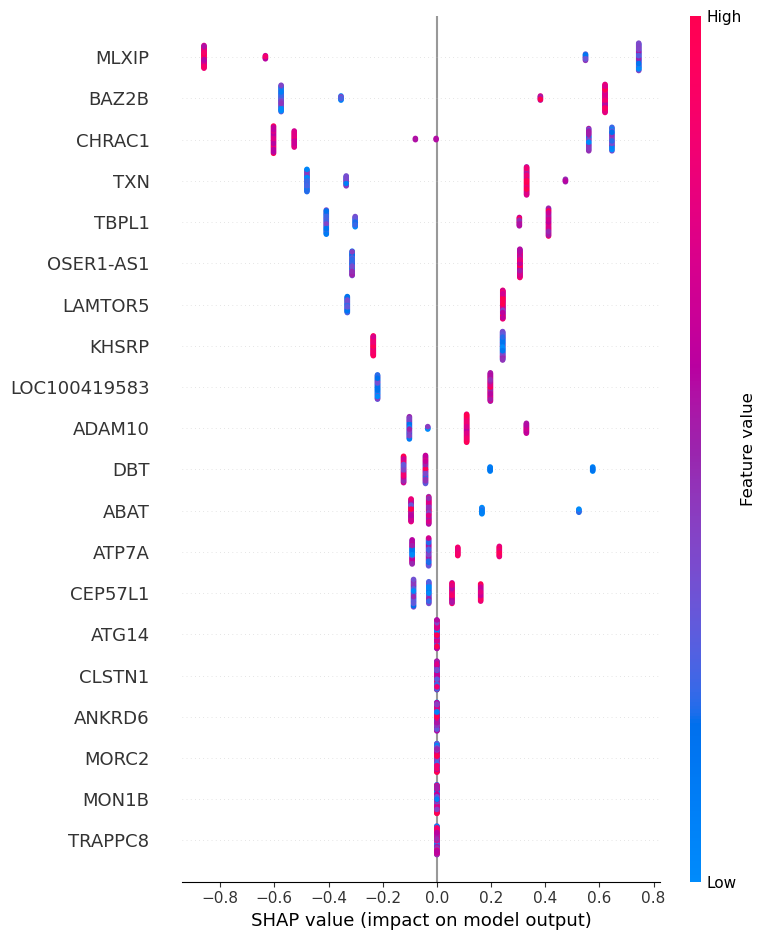

In [16]:
shap.initjs()

# Apply the generated model to the whole dataset and calculate the shap values
shap_values = shap.TreeExplainer(model).shap_values(data)  
explainer = shap.TreeExplainer(model, data)
expected_value = explainer.expected_value

features = data.columns

# Convert data DF to array
data_ = data.to_numpy()

# Run predictions for the whole dataset
d_data = xgb.DMatrix(data, label=y)

preds_data = model.predict(d_data)
prediction_data =[]
for i in preds_data:
    if i >=0.5:
        prediction_data.append(1)
    else:
        prediction_data.append(0)

# Print the shap summary plot
shap.summary_plot(shap_values, data, feature_names=data.columns) 

### SHAP force plots

https://medium.com/dataman-in-ai/explain-your-model-with-the-shap-values-bc36aac4de3d

Each feature has a shap value contributing to the prediction

The final prediction = the average prediction + the shap values of all features

The output value (f(x)) is the prediction for that observation

The base value is "the value that would be predicted if we did not know any features for the current output." In other words, it is the mean prediction, or mean(yhat)

Red/Blue: features that push the prediction higher (to the right) are shown in red, and those pushing the prediction lower are in blue

In [17]:
# Rank the clinical data by disease activity, in this case CRP.DAS28, and get the positions of the 5 patients
# with the highest disease activity and the 5 patients with the lowest (in this case these will be healthy controls)

DAranking = clin[['CRP.DAS28']]
DAranking.insert(loc=0, column="rowPosition", value=np.arange(len(DAranking))) # column with row position
DAranking = DAranking.sort_values(by = 'CRP.DAS28', ascending = False)         # sort CRP.DAS28 in descending order
DAranking.insert(loc=0, column="DAorder", value=np.arange(len(DAranking)))     # column with CRP.DAS28 order position
DAranking = DAranking.drop(columns="CRP.DAS28")

# Get row positions of top 5
positionlist = DAranking["rowPosition"].tolist()
TopDA = positionlist[:5]
print("TOP 5 DA rows", TopDA)

# Get row positions of bottom 5
positionlist.reverse()
BotDA = positionlist[:5]
print("BOTTOM 5 DA rows", BotDA)

# Disease activity scores into a series        
DA = clin[['CRP.DAS28']]
DA = DA.to_numpy()

TOP 5 DA rows [78, 39, 27, 62, 53]
BOTTOM 5 DA rows [52, 51, 50, 49, 48]


In [18]:
# A function that displays the actual value, the predicted value and the disease activity score (CRP.DAS28) 
# that is added to the force plot 
# Adapted from Max Steele def shap_force 
# https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195

def shap_accuracy(prediction_list, index, y_values, DA_values):
    pred = prediction_list[index]
    
    true_label = y_values[index]
    
    DA = DA_values[index]
    
    ## Assess accuracy of prediction
    if true_label == pred:
        accurate = 'Correct'
    else:
        accurate = 'Incorrect'
        
    ## Print output that checks model's prediction against true label
    print('***'*12)
    # print ground truth label for row at index
    print(f'Ground Truth Label: {true_label}')
    # Print model prediction for row at index
    print(f'Model Prediction:  {pred} -- {accurate}')
    # print disease activity score
    print(f'Score: {DA}')
    print('***'*12)
    print()

************************************
Ground Truth Label: 1
Model Prediction:  1 -- Correct
Score: [7.57]
************************************



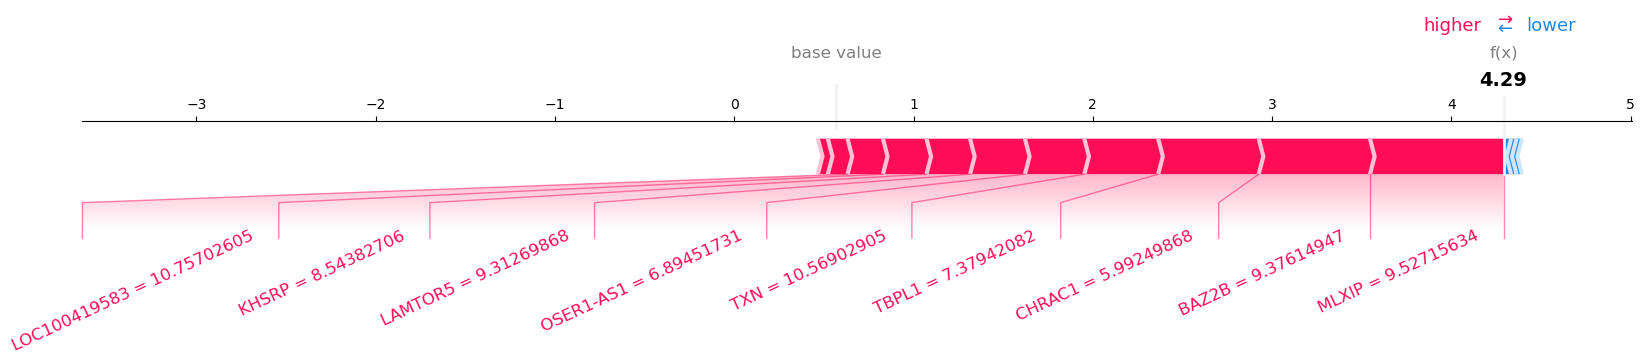

************************************
Ground Truth Label: 1
Model Prediction:  1 -- Correct
Score: [6.42]
************************************



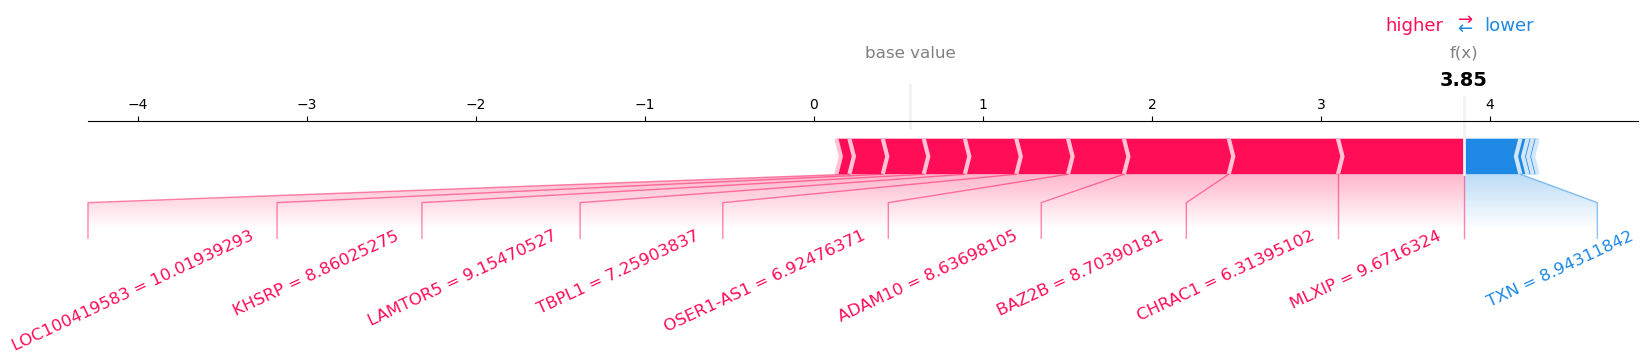

************************************
Ground Truth Label: 1
Model Prediction:  1 -- Correct
Score: [6.05]
************************************



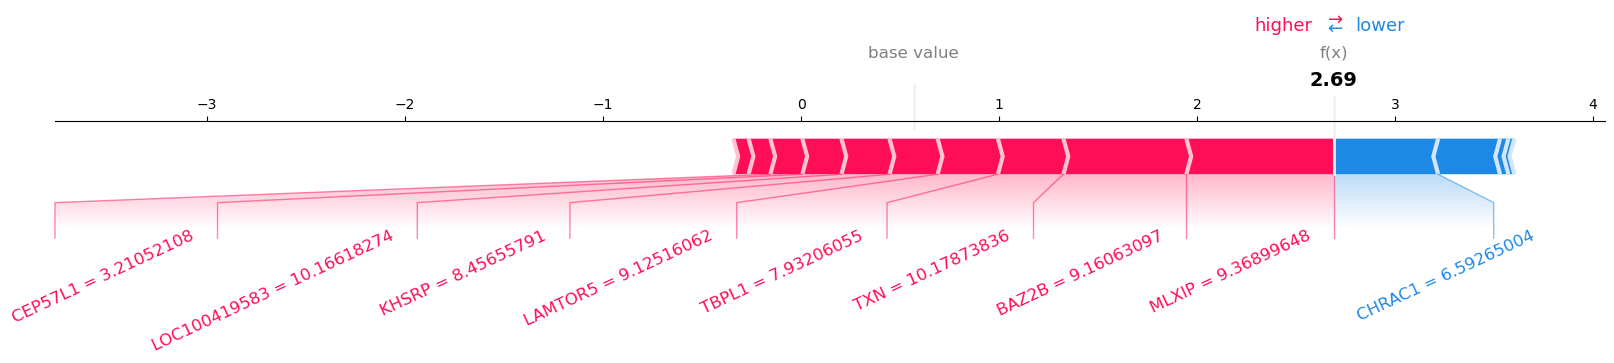

************************************
Ground Truth Label: 1
Model Prediction:  1 -- Correct
Score: [6.05]
************************************



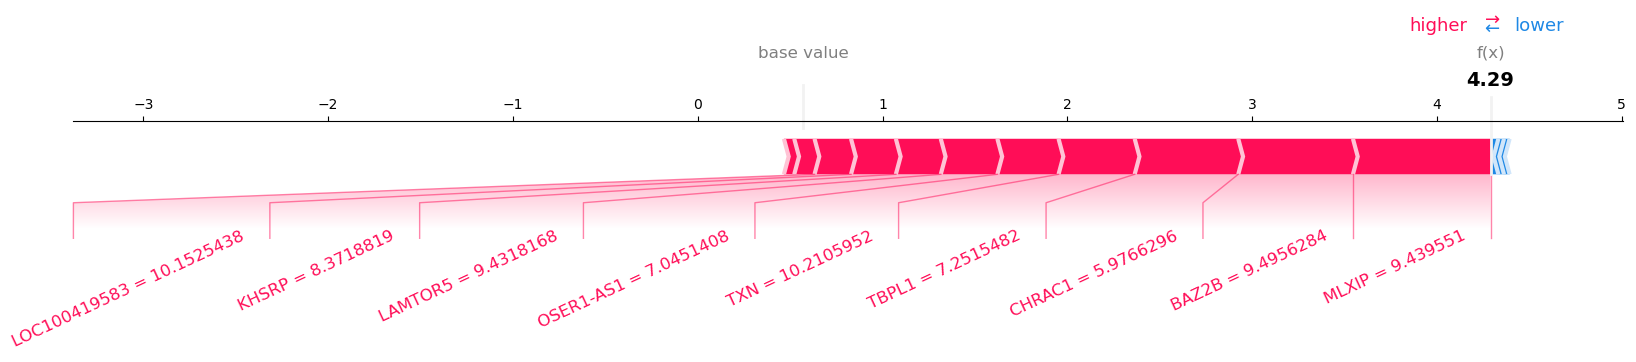

************************************
Ground Truth Label: 1
Model Prediction:  1 -- Correct
Score: [5.93]
************************************



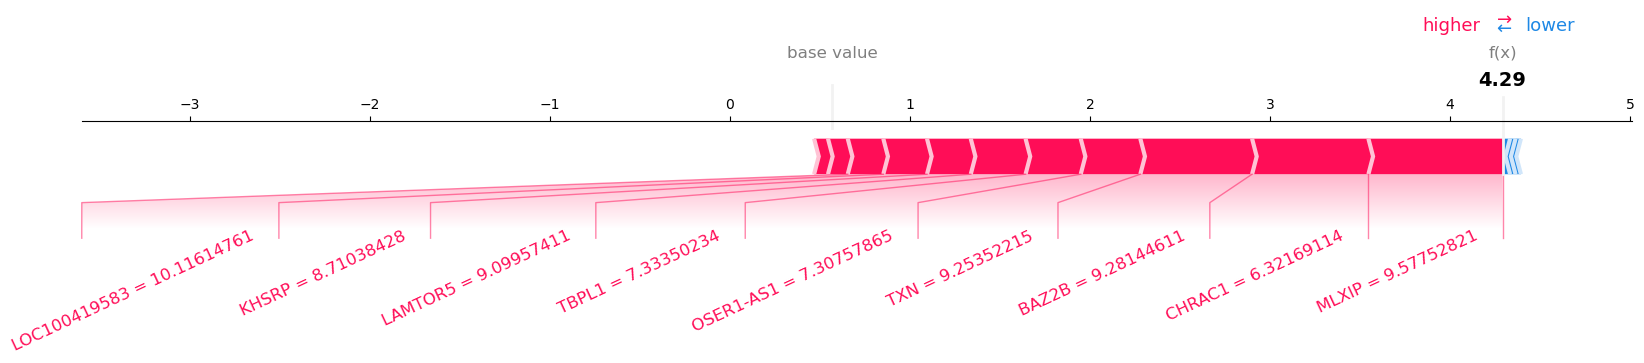

In [19]:
# Force plots for top 5 CRP.DAS28
for i in TopDA:
    shap_accuracy(prediction_data, i, y, DA)
    shap.force_plot(expected_value, shap_values[i], data_[i], feature_names = features,
                matplotlib = True, plot_cmap="PkYg", text_rotation = 25)

************************************
Ground Truth Label: 0
Model Prediction:  0 -- Correct
Score: [nan]
************************************



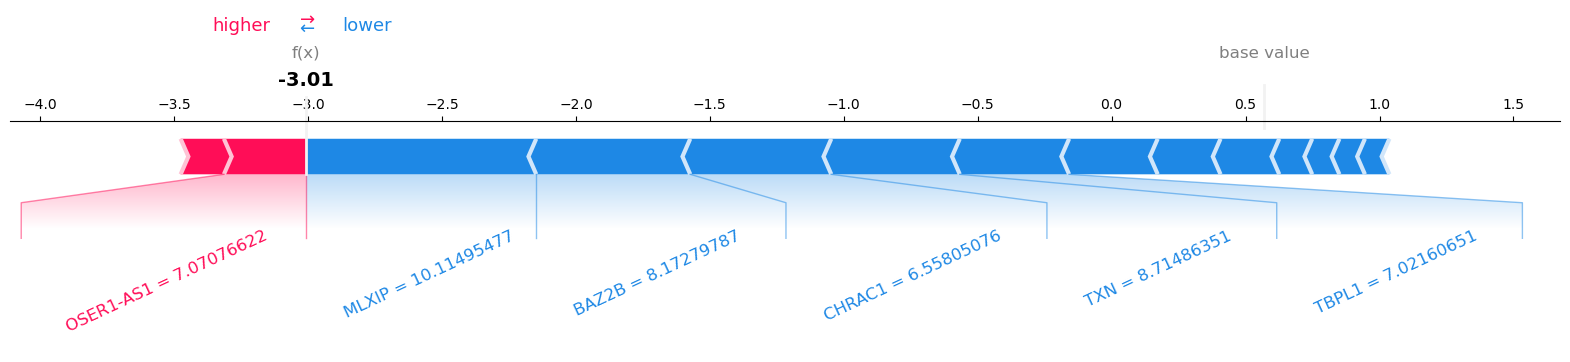

************************************
Ground Truth Label: 0
Model Prediction:  0 -- Correct
Score: [nan]
************************************



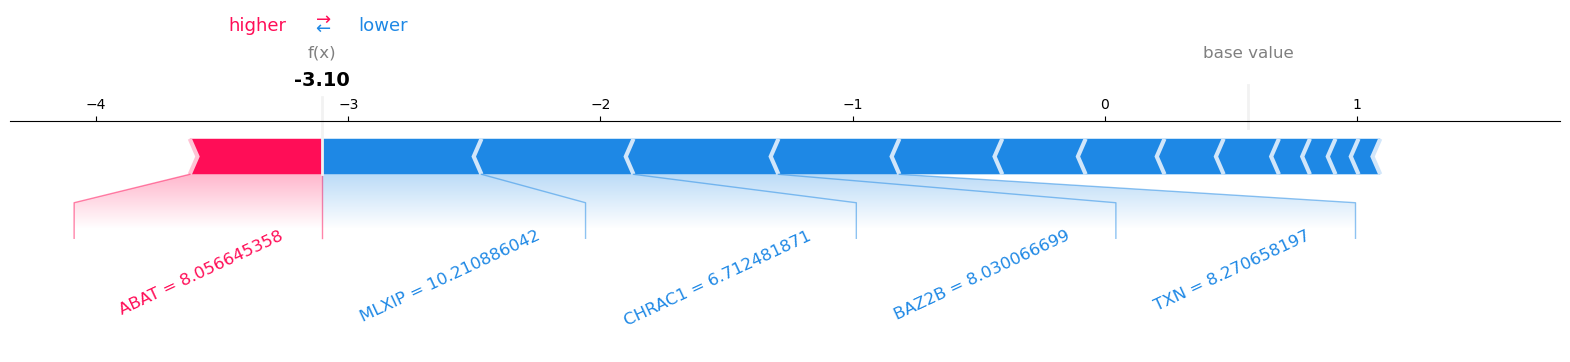

************************************
Ground Truth Label: 0
Model Prediction:  0 -- Correct
Score: [nan]
************************************



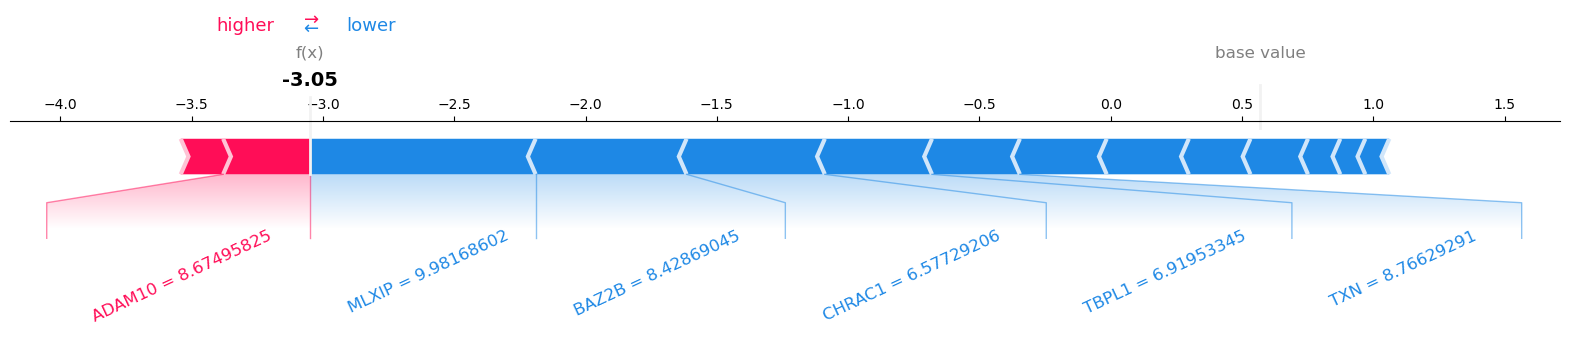

************************************
Ground Truth Label: 0
Model Prediction:  0 -- Correct
Score: [nan]
************************************



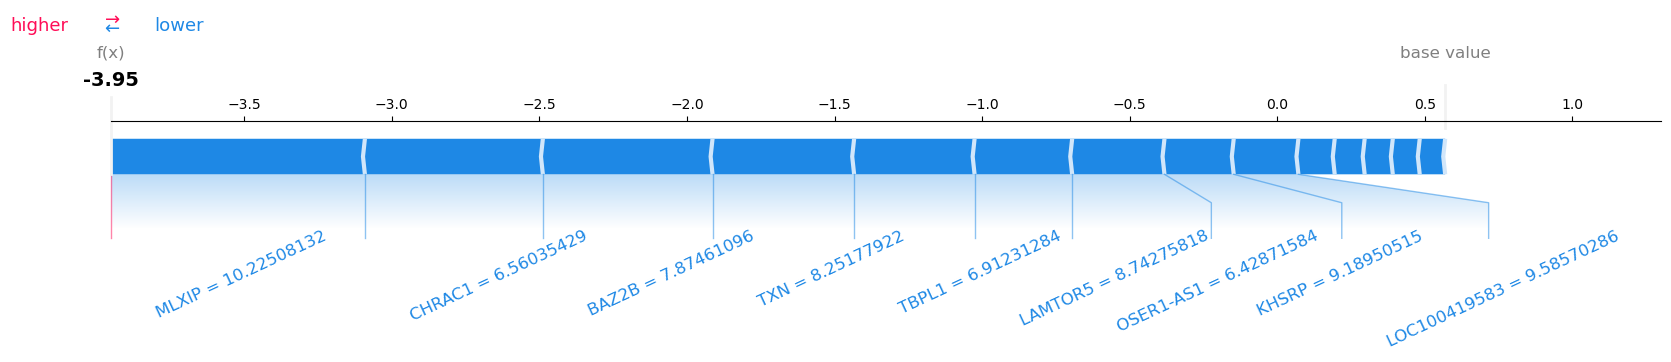

************************************
Ground Truth Label: 0
Model Prediction:  0 -- Correct
Score: [nan]
************************************



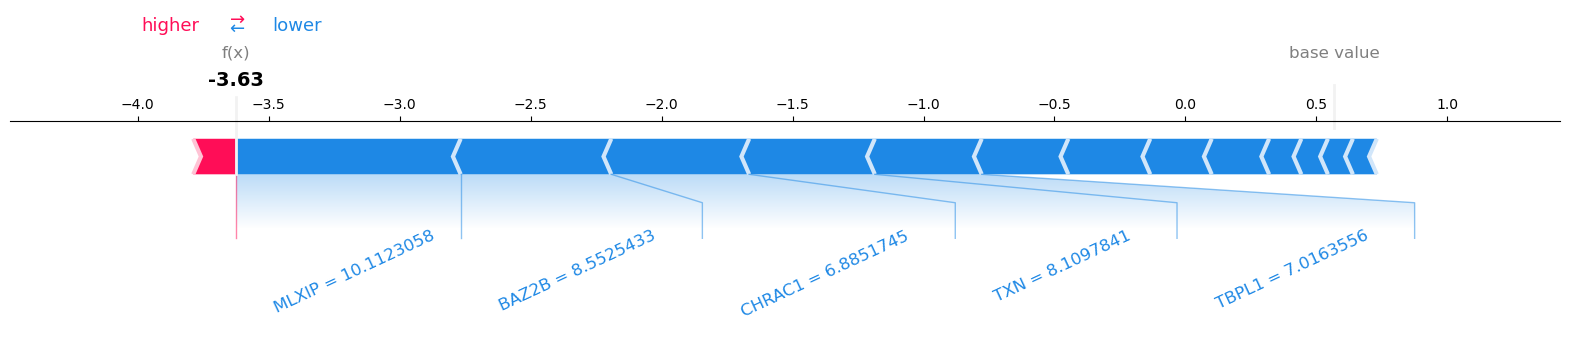

In [20]:
# Force plots for bottom 5 CRP.DAS28 (healthy controls)
for i in BotDA:
    shap_accuracy(prediction_data, i, y, DA)
    shap.force_plot(expected_value, shap_values[i], data_[i], feature_names = features,
                matplotlib = True, plot_cmap="PkYg", text_rotation = 25)